The outlier detection algorithm based on KMeans clustering requires validation that would determine the reconstruction error threshold. The threshold is the cut off value, which dictates whether a tested light curve is dissimilar enough to the training light curves to be labeled as an outlier.
In order to establish this value for the light curves of the rho class (the heartbeat), KMeans clustering was performed on nine training rho observations. Light curves of different classes were then reconstructed using the centroids of those clusters.

Minimised cells include the code for 1.preparing light curve data and splitting into sets, 2.segmenting light curves of the rho class from the training set and fitting a model to them, 3.reconstructing a light curves from the validation set

In [80]:
# my horrible spaghetti that imports and prepares the data, and then splits it into training, validation and test sets 

import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import segment_cluster as sc
import importlib
importlib.reload(sc)
from sklearn.cluster import KMeans
import pandas as pd


cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path for data directory!", Flush=True)

clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
####### due to the energy integration in Std1 diefferences between different epochs shouldn't matter; there would be very few photons found at the extremes of the range            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
#a list of light curve 2D arrays

lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
#a list of light curve 2D arrays of classes with at least 7 light curves

lcs_abu_std=sc.scaling(lcs_abu, method="standard")
# data is standardised, x_i_stand = (x_i - x_mean)/x_std
# mean+n*sigma is going to be the assumed maximum count rate that will be used to normalise the data

x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu_std, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)
x_valid, x_test, y_valid, y_test, id_valid, id_test = train_test_split(x_test, y_test, id_test, test_size=0.5, random_state=0, stratify=y_test)

In [276]:
##train the model
model_class="rho"
n_clusters=100
length=50
time_stamps=False
offset=True
training_ys=np.where(np.array(y_train)=='{}'.format(model_class))[0]
all_train_segments=[]
for ts_i in training_ys:
    ts=x_train[ts_i]
    train_segments=sc.segmentation(ts, length, 2, time_stamps=time_stamps)
    c_train_segments=sc.center_offset(train_segments, ts, offset=offset, time_stamps=time_stamps)
    all_train_segments.append(c_train_segments)
all_train_segments=np.vstack(all_train_segments)
if proportion > len(all_train_segments): proportion = len(all_train_segments)
cluster=KMeans(n_clusters=n_clusters, random_state=0)
cluster.fit(all_train_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

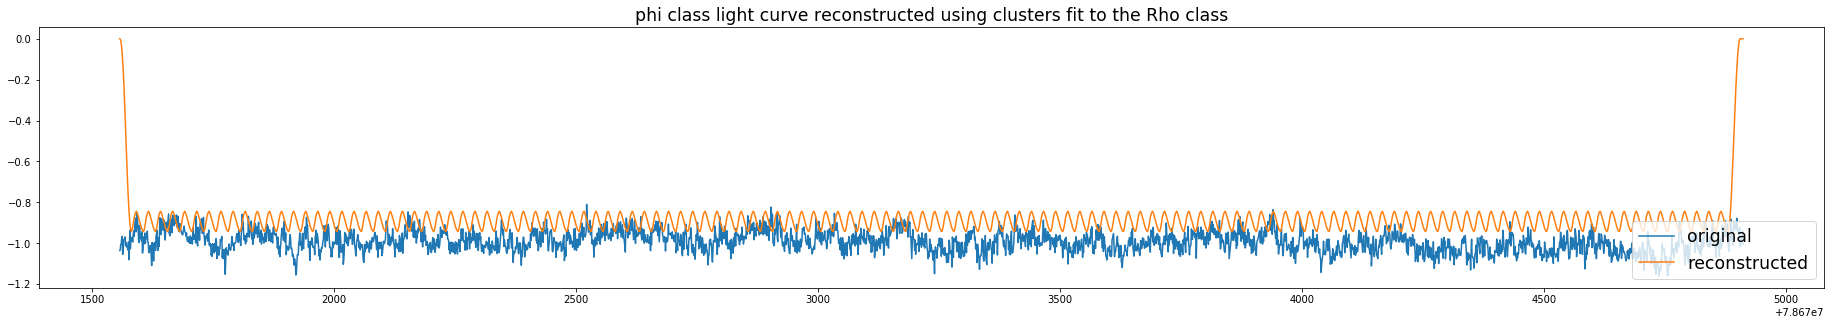

Root mean squared error of reconstruction: 0.11632730672570023


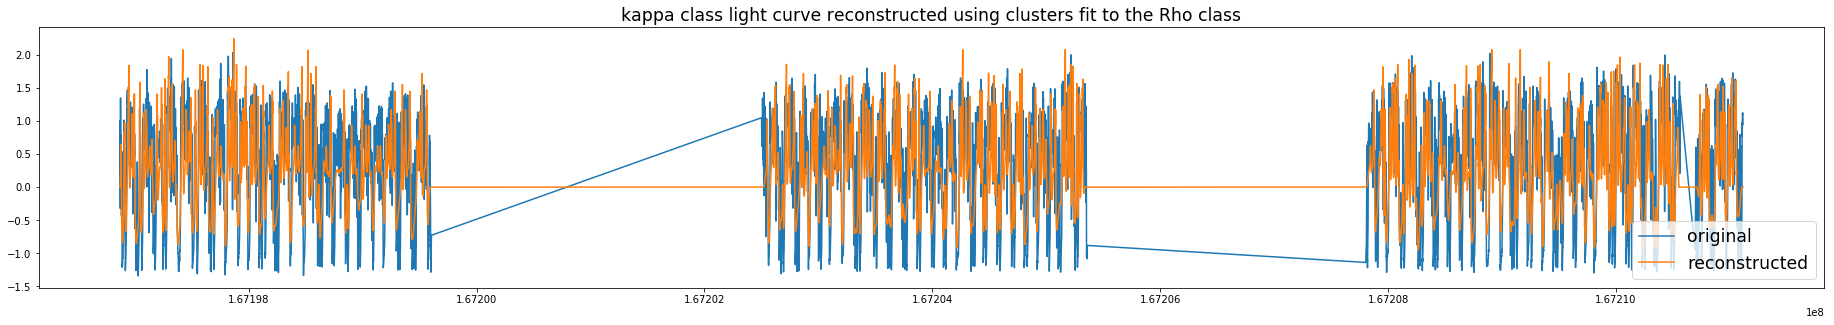

Root mean squared error of reconstruction: 0.5967231424345106


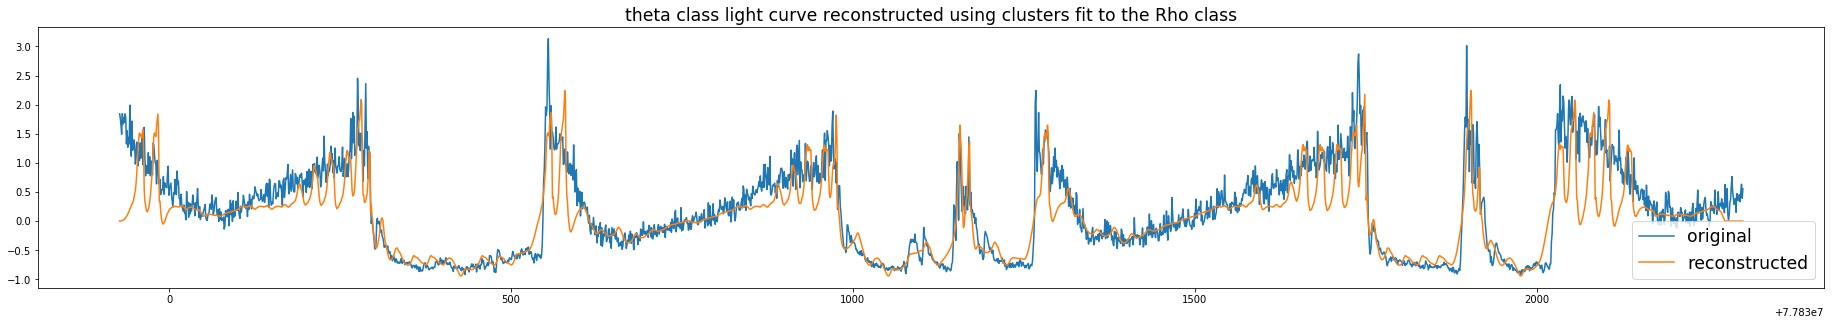

Root mean squared error of reconstruction: 0.39243494768604226


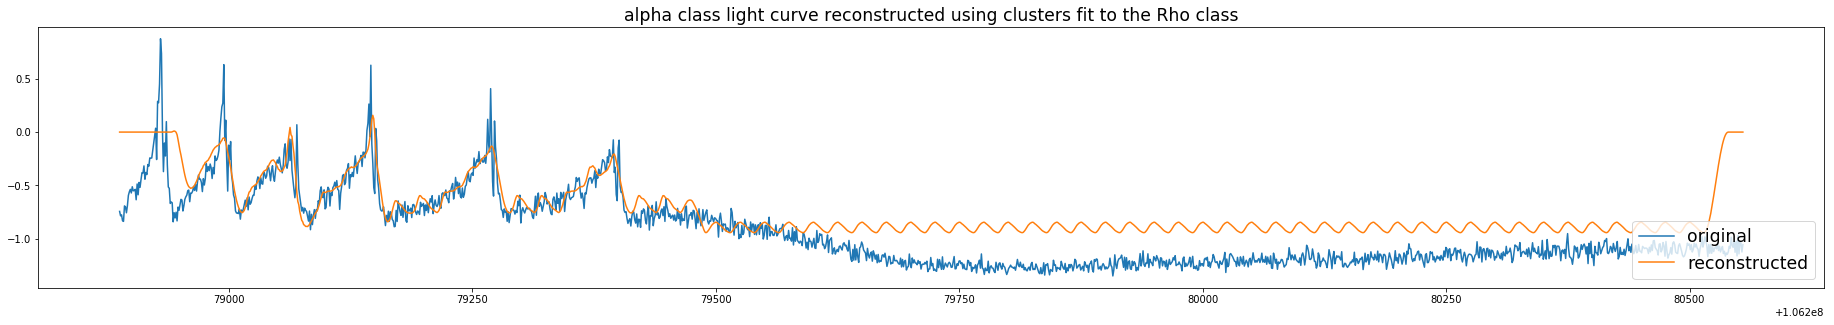

Root mean squared error of reconstruction: 0.25012900740470706


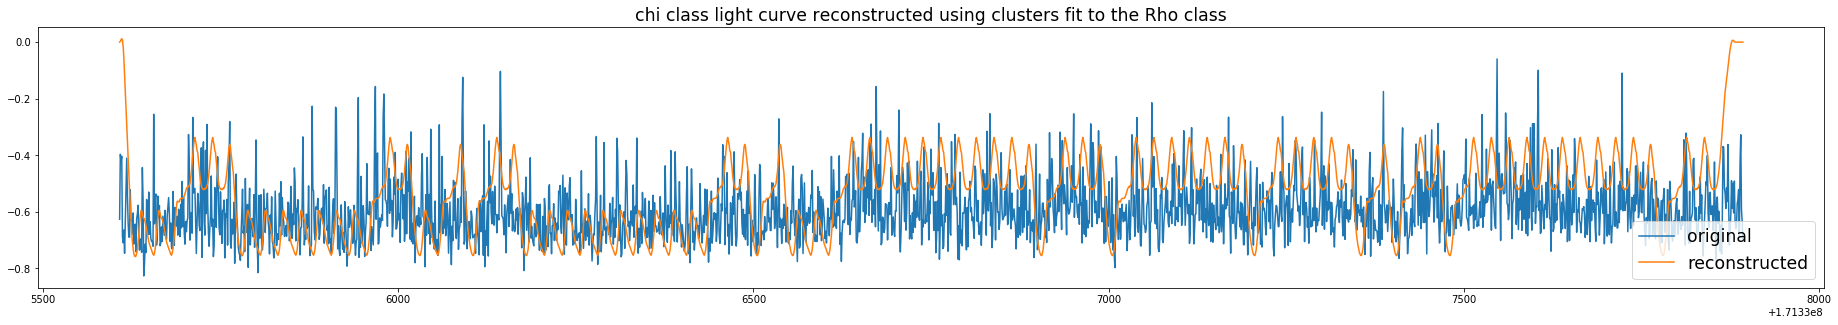

Root mean squared error of reconstruction: 0.15229662259641183


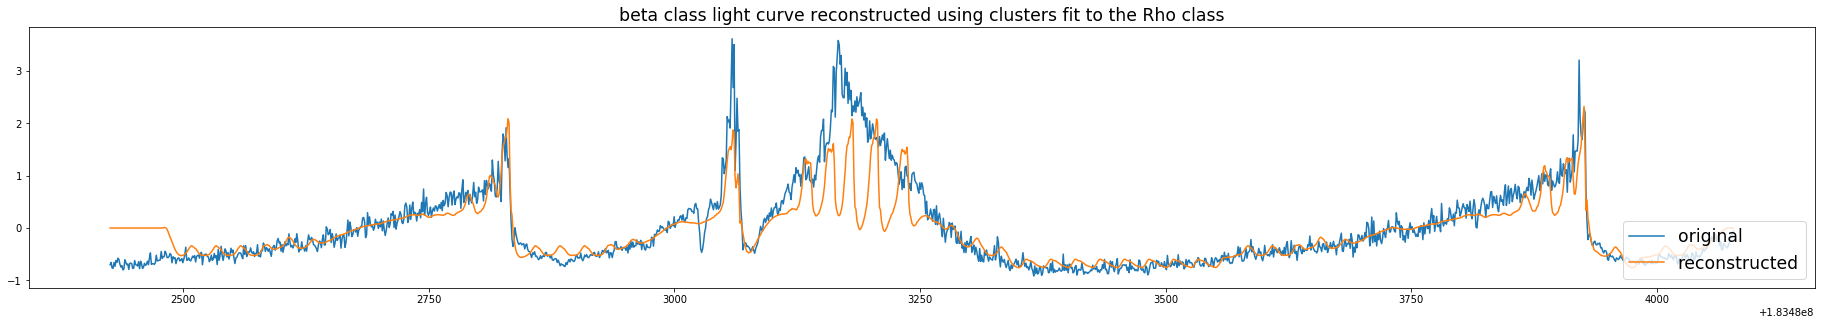

Root mean squared error of reconstruction: 0.4254986940845377


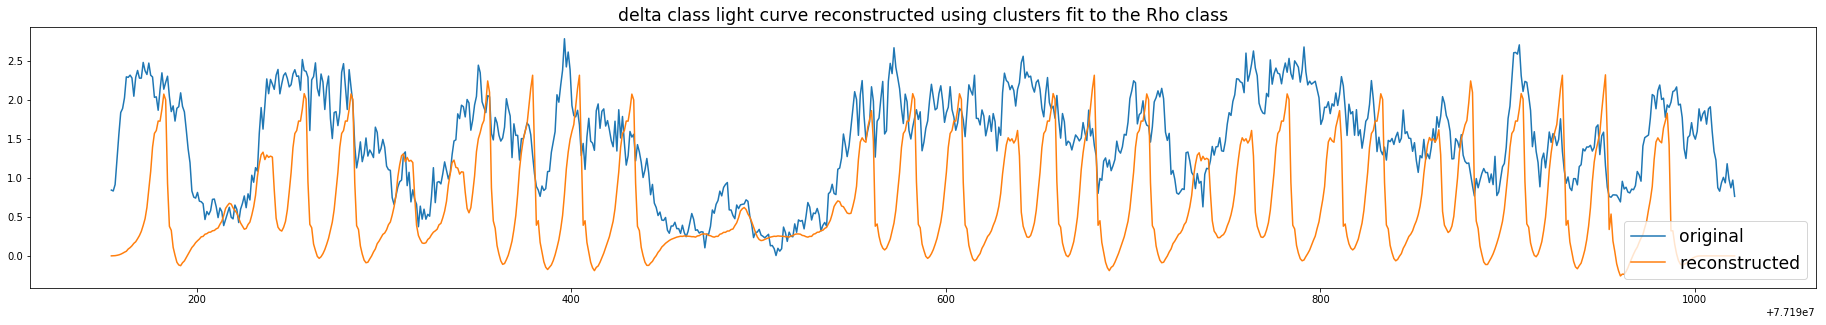

Root mean squared error of reconstruction: 1.0523647041530841


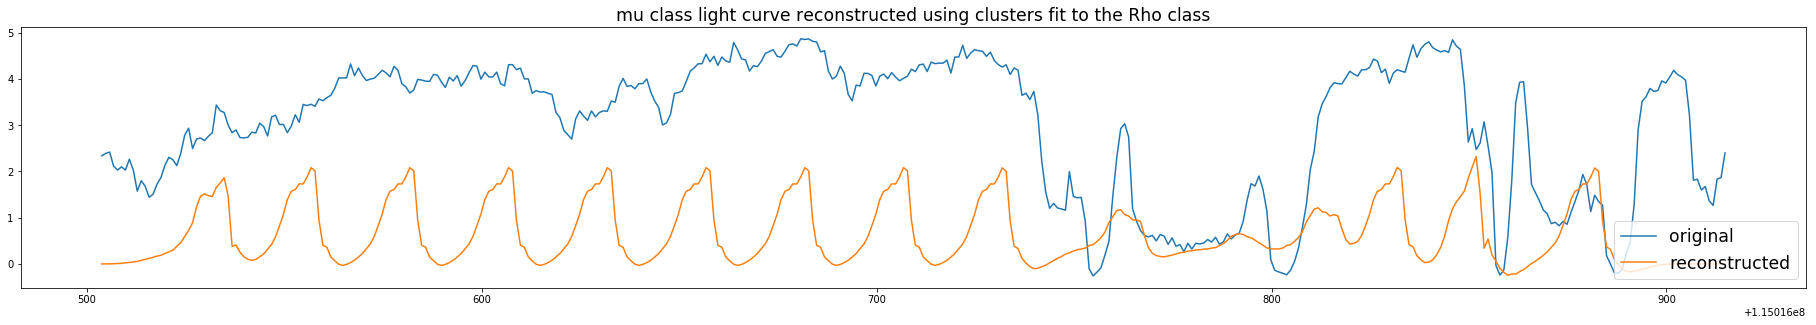

Root mean squared error of reconstruction: 2.920568735146281


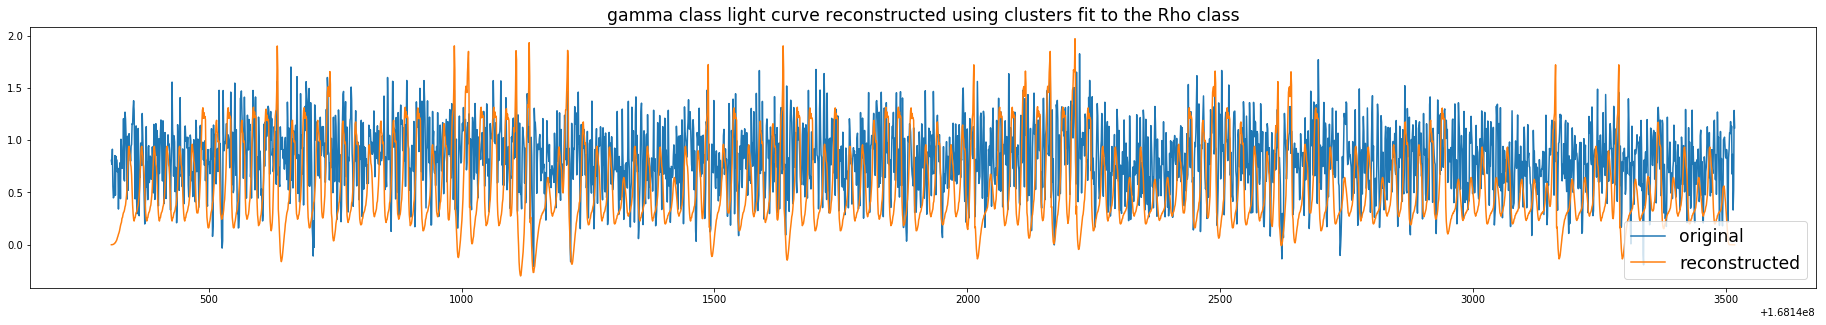

Root mean squared error of reconstruction: 0.5061862996963834


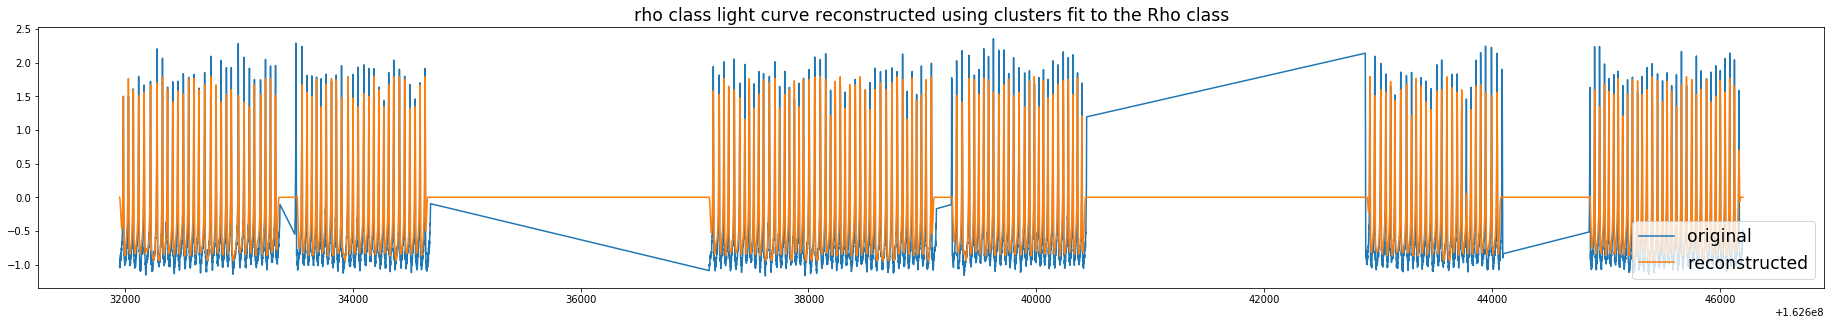

Root mean squared error of reconstruction: 0.27926110533277604


In [277]:
# reconstruct an observation of each tested class. 
importlib.reload(sc)
classes=list(set(y_valid))
for class_current in classes:
    if class_current == "alpha":
        n=1
    else:
        n=0
    ts_id=np.where(np.array(y_valid)==class_current)[0][n]
    time_stamps=True
    offset=False
    reco_error=[]
    seg_len=length
    seg_slide=int(length*0.5)

    test_ts=x_valid[ts_id]
    test_segments= sc.segmentation(test_ts, seg_len, seg_slide, time_stamps=time_stamps)
    c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)
    reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)
    error=np.sqrt(np.mean((test_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
    plt.figure(figsize=(6.4*5, 4.8))
    plt.plot(test_ts[0], test_ts[1])
    plt.plot(reco[0],reco[1])
    plt.legend(("original", "reconstructed"), fontsize="xx-large", loc='lower right')
    plt.title("{} class light curve reconstructed using clusters fit to the Rho class".format(class_current), fontsize="xx-large")
    plt.show()
    print("Root mean squared error of reconstruction: {}".format(error))

The reconstruction error was defined as the difference between data points of the original and reconstructed light curves. The root mean squared error of reconstruction was hence calculaed as: 

$RMSE  = \sqrt{\frac{\sum_{i=1}^N (y_i-\hat{y}_i)^2}{N}}$
where $y_i$ and $\hat{y}_i$  are the standardised count rate values of the original and the reconstructed y light curve respectively.

Above plots show that the most visually accurate reconstruction was produced for the rho class light curve as expected. However, lower root mean squared error values were achieved for the reconstructions of phi, chi and alpha classes. This seems to be a general issue with light curves that show low variability of count rate; small variability fragments produce small reconstruction error even though it does not reproduce the shape accurately. In case of the alpha light curve, even the small reflares were followed closely.

Intuitively, changing the size of the fragments and the number of clusters that the algorithm trains on should minimise this issue, as there would be less flexibility in the shapes that could be fit, especially for longer fragments and fewer clusters.

Reconstruction was repeated on the remainder of the validation light curves. The reconstruction of all validation light curves of a single class was treated as a batch, and the mean RSME value of every batch was recorded. The mean RMSE value of the rho batch was subtracted, so that negative differences indicate batches with lower mean RSME than the rho batch. The procedure was repeated for a range of values of two hyper-parameters; the segment length and the number of clusters. 

In [250]:
pro_clusters=[4,6,8,10,20,50,100]
seg_lens=[5,10,20,30,50,100,200]
#results[n_pro, n_len, n_model, n_test, 0]  3 4 9 9, 
data=np.loadtxt("/home/jkok1g14/Documents/timeseries_segment_clustering/model_errors_2019-02-19_v1.csv", delimiter=",")
np.shape(data)
data_fold=data.reshape((7,7,10,2))
neg_counts=np.zeros((7,7))
neg_sums=np.zeros((7,7))
sum_dif=np.zeros((7,7))
min_dif=np.zeros((7,7))
neg_classes=np.empty((7,7), dtype=object)
classes=['alpha', 'beta', 'chi', 'delta', 'gamma', 'kappa', 'mu', 'phi', 'rho', 'theta']
rho=np.where(np.array(classes)=="rho")[0][0]
for c, cluster in enumerate(data_fold):
    for l, length in enumerate(cluster):
        neg_count=0
        neg_sum=0
        neg_class=""
        for n, val in enumerate(length):
            val[0]-=length[rho][0]
            if val[0]<0:
                neg_class+="{} ".format(classes[n])
                neg_count+=1
                neg_sum+=val[0]
            #print(val, classes[n])
        sum_dif[c,l]=np.sum(length[:,0])
        neg_counts[c,l]=neg_count
        neg_sums[c,l]=neg_sum    
        neg_classes[c,l]=neg_class
        min_dif[c,l]=np.min(length[:rho,0])
        if np.min(length[rho+1:,0])<min_dif[c,l]: 
            min_dif[c,l]=np.min(length[rho+1:,0])
#         print(np.where(length[:,0]==min_dif[c,l]))
        
min_df=pd.DataFrame(min_dif, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
sum_df=pd.DataFrame(sum_dif,  columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
neg_counts_df=pd.DataFrame(neg_counts,dtype=int, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
neg_sums_df=pd.DataFrame(neg_sums, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
neg_classes_df=pd.DataFrame(neg_classes, dtype=str, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])

In [267]:
print("The sum RMSE differences (the larger the better). The maximum reached at 100s segments and 6 clusters.")
sum_df

The sum RMSE differences (the larger the better). The maximum reached at 100s segments and 6 clusters.


,5s segments,10s segments,20s segments,30s segments,50s segments,100s segments,200s segments
4 clusters,2.395103,2.550627,3.145621,3.589057,4.862742,5.720675,5.567869
6 clusters,1.948354,2.560338,3.254911,4.069166,4.961352,5.970579,5.233637
8 clusters,1.805459,2.535079,3.191086,3.935724,5.221099,5.748804,5.308188
10 clusters,1.783700,2.460966,3.194127,4.082195,5.161113,5.311383,4.554563
20 clusters,1.510437,2.218597,2.697023,3.518375,4.579332,5.062741,4.716556
50 clusters,1.271472,1.981623,2.590602,3.370133,4.022065,4.800216,4.862746
100 clusters,1.106963,1.885967,2.458094,3.041447,4.031361,4.713813,5.241957


In [268]:
print("Classes of light curves which produced negative RMSE differences. Optima found at 5s/8c, 100s/6c, 100s/8c and 100s/10c.")
neg_classes_df

Classes of light curves which produced negative RMSE differences. Optima found at 5s/8c, 100s/6c, 100s/8c and 100s/10c.


,5s segments,10s segments,20s segments,30s segments,50s segments,100s segments,200s segments
4 clusters,phi,phi,phi,chi phi,phi,phi,phi
6 clusters,phi,phi,phi,phi,phi,,phi
8 clusters,,phi,phi,phi,phi,,phi
10 clusters,phi,phi,phi,phi,phi,,alpha chi phi
20 clusters,phi,phi,phi,phi,phi,alpha chi phi,alpha chi phi
50 clusters,phi,phi,phi,phi,alpha phi,alpha phi,alpha chi phi
100 clusters,phi,phi,phi,alpha chi phi,alpha phi,alpha phi,alpha chi phi


In [269]:
print("The smallest non-zero RMSE differences (the larger the better). Optimum at 100s/6c")
min_df

The smallest non-zero RMSE differences (the larger the better). Optimum at 100s/6c


,5s segments,10s segments,20s segments,30s segments,50s segments,100s segments,200s segments
4 clusters,-0.005186,-0.051281,-0.028715,-0.061182,-0.052575,-0.018710,-0.069891
6 clusters,-0.004837,-0.021527,-0.052183,-0.028617,-0.047960,0.032064,-0.084680
8 clusters,0.000790,-0.018133,-0.036280,-0.063416,-0.042064,0.018841,-0.063456
10 clusters,-0.002167,-0.017018,-0.043323,-0.052754,-0.057972,0.008833,-0.241275
20 clusters,-0.009820,-0.028514,-0.041424,-0.045800,-0.056954,-0.065116,-0.204660
50 clusters,-0.022280,-0.033752,-0.047952,-0.056388,-0.088782,-0.072134,-0.173173
100 clusters,-0.021104,-0.033686,-0.053379,-0.071343,-0.081170,-0.081826,-0.019283


Hyper-parameters which produced the largest mean RMSE difference between rho and other reconstructions were 100s segments and 6 KMeans clusters. Values used for the reconstructions plotted at the top of this document were 50s/100c. When the same reconstructions were done with the 100s/6c setting, the reconstruction error increased for all classes of light curves, including rho. This time, the only class that produced a smaller RMSE value was chi.

It does not seem possible to solve the problem of classes that show small variability by adjusting the hyper-parameters.  

In [278]:
##train the model
model_class="rho"
n_clusters=6
length=100
time_stamps=False
offset=True
training_ys=np.where(np.array(y_train)=='{}'.format(model_class))[0]
all_train_segments=[]
for ts_i in training_ys:
    ts=x_train[ts_i]
    train_segments=sc.segmentation(ts, length, 2, time_stamps=time_stamps)
    c_train_segments=sc.center_offset(train_segments, ts, offset=offset, time_stamps=time_stamps)
    all_train_segments.append(c_train_segments)
all_train_segments=np.vstack(all_train_segments)
if proportion > len(all_train_segments): proportion = len(all_train_segments)
cluster=KMeans(n_clusters=n_clusters, random_state=0)
cluster.fit(all_train_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

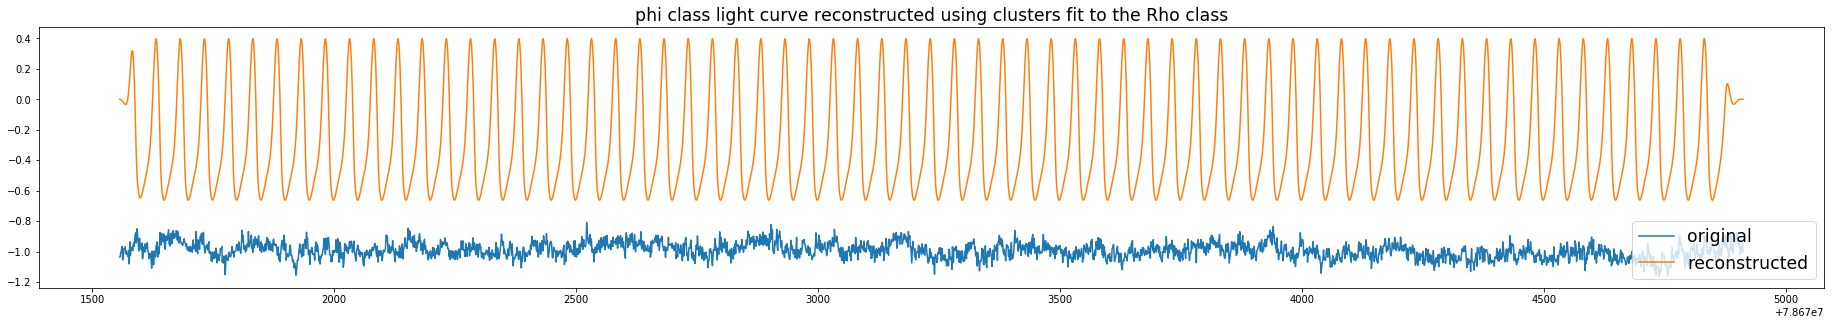

Root mean squared error of reconstruction: 0.8048644606460641


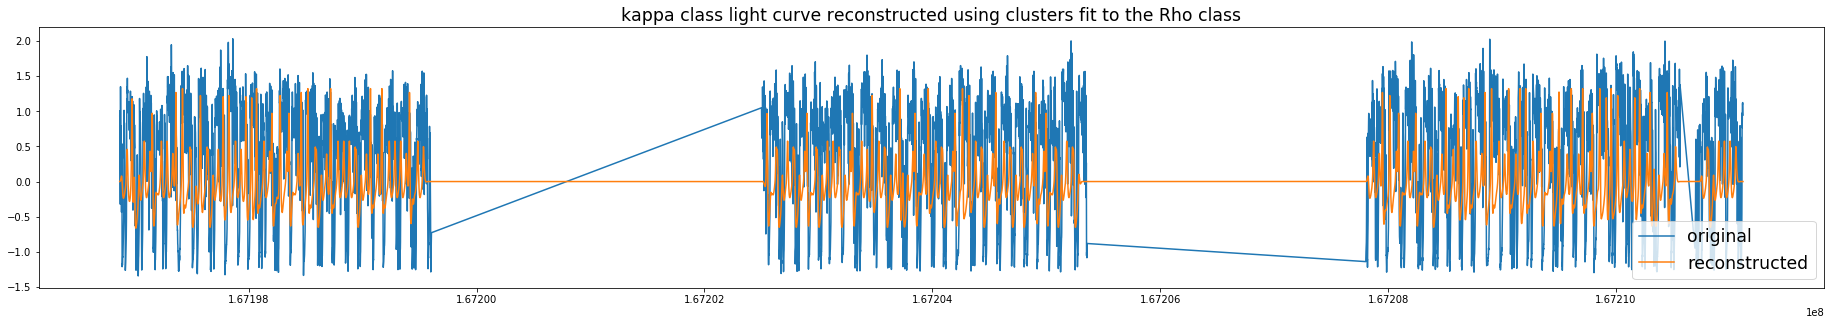

Root mean squared error of reconstruction: 0.8452131523303371


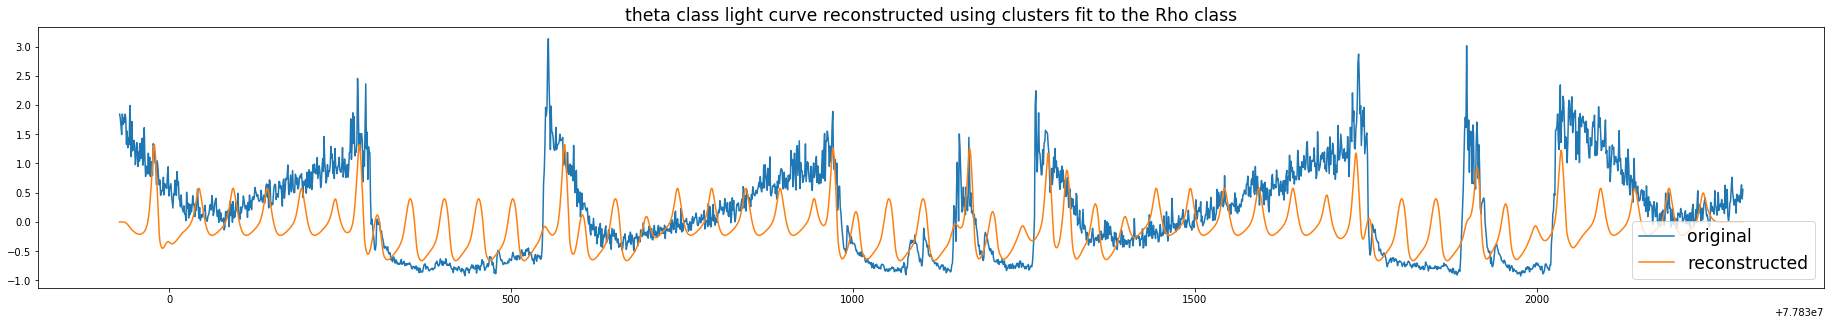

Root mean squared error of reconstruction: 0.7252412760391296


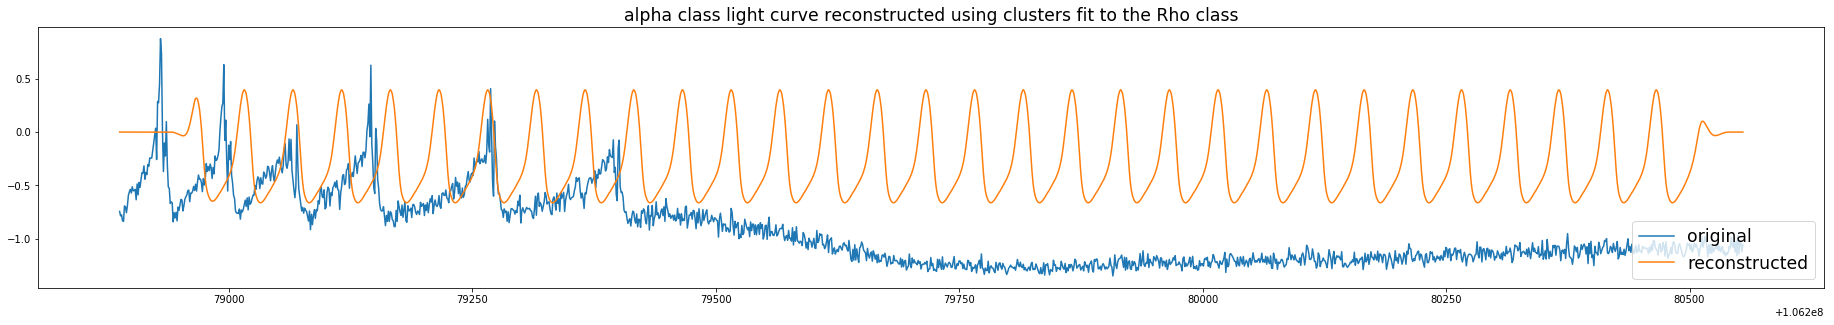

Root mean squared error of reconstruction: 0.8367185021031985


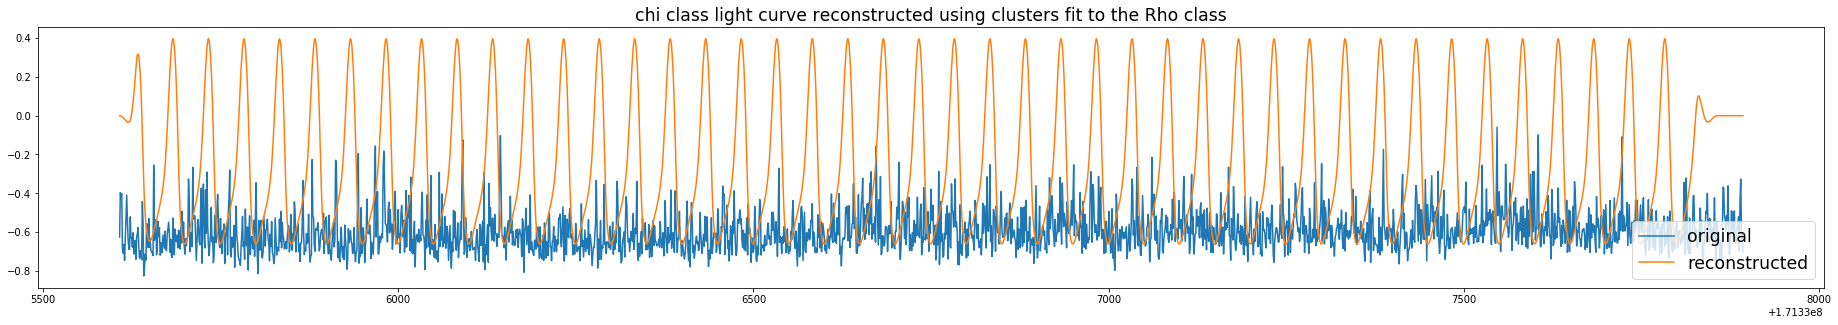

Root mean squared error of reconstruction: 0.49343135436865626


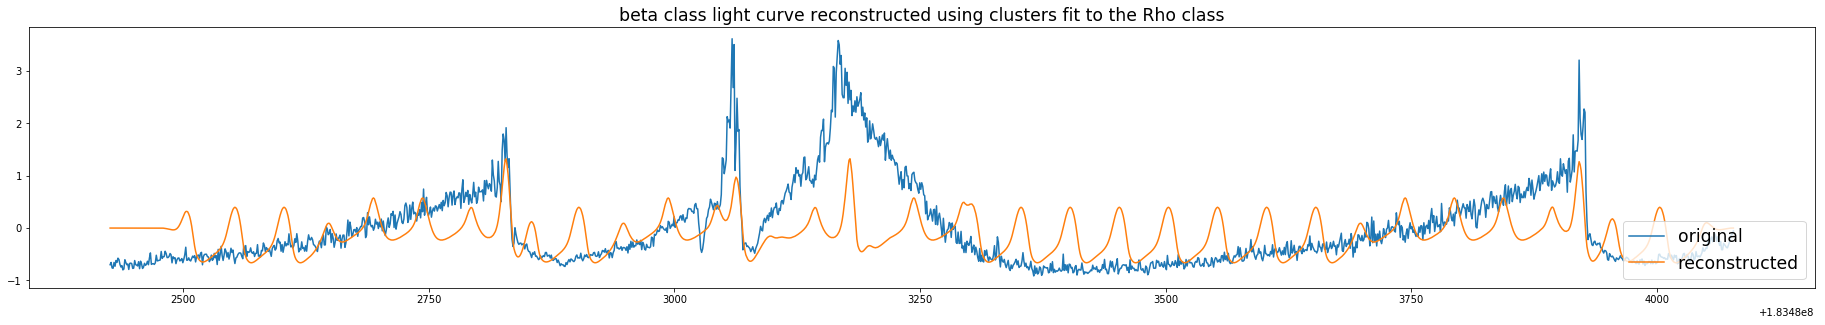

Root mean squared error of reconstruction: 0.7363655883128476


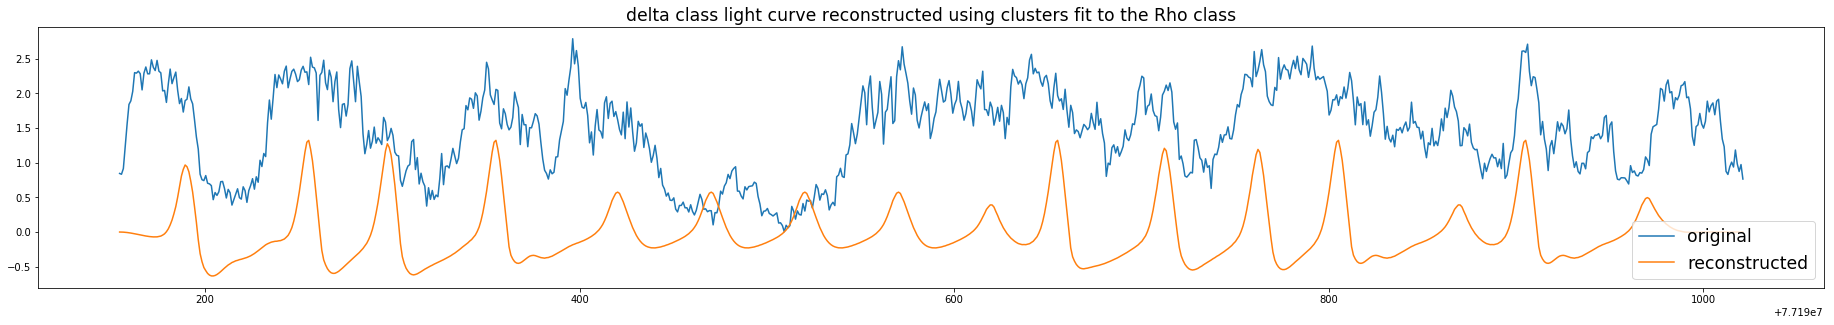

Root mean squared error of reconstruction: 1.635748383992926


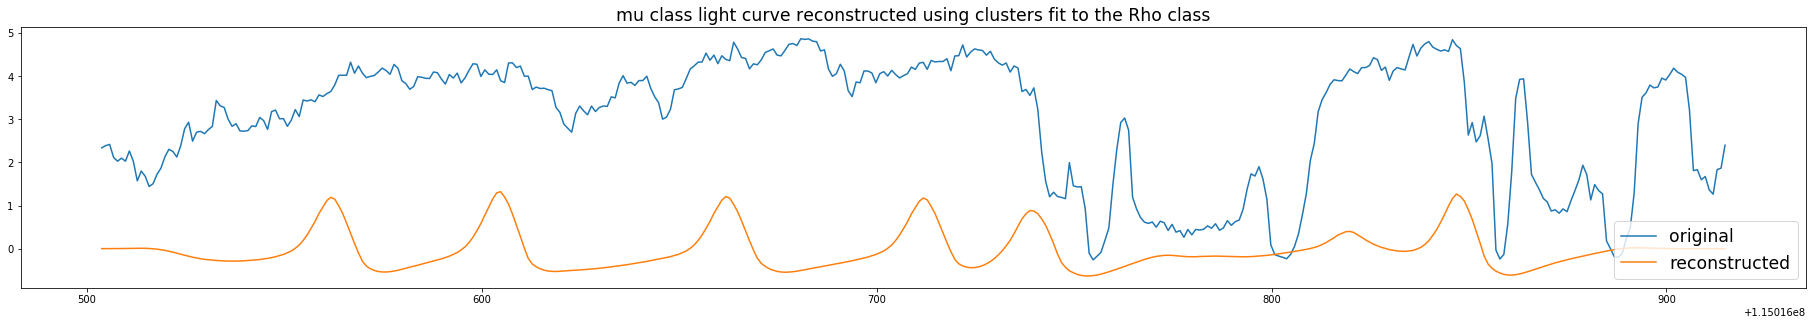

Root mean squared error of reconstruction: 3.435448435368082


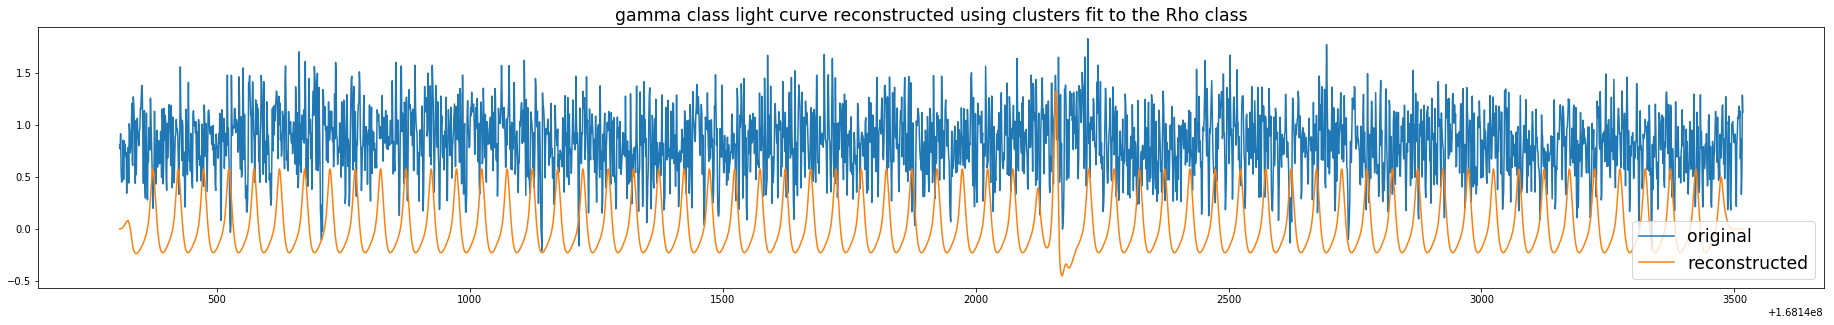

Root mean squared error of reconstruction: 0.8979223268518695


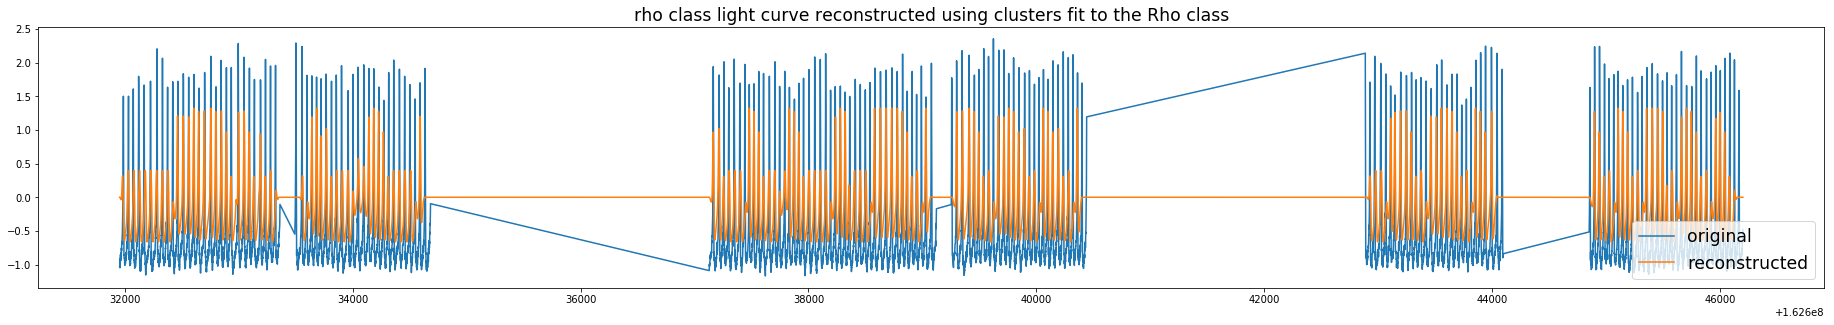

Root mean squared error of reconstruction: 0.6454328535616025


In [279]:
# reconstruct an observation of each tested class. 
importlib.reload(sc)
classes=list(set(y_valid))
for class_current in classes:
    if class_current == "alpha":
        n=1
    else:
        n=0
    ts_id=np.where(np.array(y_valid)==class_current)[0][n]
    time_stamps=True
    offset=False
    reco_error=[]
    seg_len=length
    seg_slide=int(length*0.5)

    test_ts=x_valid[ts_id]
    test_segments= sc.segmentation(test_ts, seg_len, seg_slide, time_stamps=time_stamps)
    c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)
    reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)
    error=np.sqrt(np.mean((test_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
    plt.figure(figsize=(6.4*5, 4.8))
    plt.plot(test_ts[0], test_ts[1])
    plt.plot(reco[0],reco[1])
    plt.legend(("original", "reconstructed"), fontsize="xx-large", loc='lower right')
    plt.title("{} class light curve reconstructed using clusters fit to the Rho class".format(class_current), fontsize="xx-large")
    plt.show()
    print("Root mean squared error of reconstruction: {}".format(error))